In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import datetime
import gc
import RNN_preprocessing as rp 

RNN

In [2]:
#Reccurent Neural Network model
def model_rnn (input_shape, output_shape):
    model = keras.Sequential(
        [
            layers.SimpleRNN(64, input_shape=input_shape, activation="tanh", return_sequences=True),
            layers.SimpleRNN(32, activation="tanh"),
            layers.Dense(16, activation="relu"),
            layers.Dense(output_shape, activation="softmax"),
        ]
    )
    model.compile(loss="categorical_crossentropy", optimizer = "adam", metrics=['accuracy'])
    return model

In [3]:
#Model for the BiPo 214 chain
model1 = model_rnn((rp.seq_length, rp.X1_seq_train.shape[2]), rp.y1_seq_train.shape[1])
model1.summary()

2024-11-07 14:11:06.551880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 64)            4480      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 8180 (31.95 KB)
Trainable params: 8180 (31.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [3]:
#Model for the BiPo 212 chain
model2 = model_rnn((rp.seq_length, rp.X2_seq_train.shape[2]), rp.y2_seq_train.shape[1])
model2.summary()

2024-11-08 13:44:26.462217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 64)            4480      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 8214 (32.09 KB)
Trainable params: 8214 (32.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
#callback for reducing the learning rate and stopping early in case the loss function hits a plateau
callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, verbose=1, min_lr=1E-6),
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, baseline=None, restore_best_weights=True)
]

In [5]:
# Clear any previous session
tf.keras.backend.clear_session()
gc.collect()


941

In [7]:
# Train model 1
history1 = model1.fit(rp.X1_seq_train, rp.y1_seq_train, epochs=200, batch_size=256, verbose=2,
                      validation_data=(rp.X1_seq_val, rp.y1_seq_val),
                      callbacks=callbacks)

Epoch 1/200
17288/17288 - 241s - loss: 0.5082 - accuracy: 0.7762 - val_loss: 0.4875 - val_accuracy: 0.7889 - lr: 0.0010 - 241s/epoch - 14ms/step
Epoch 2/200
17288/17288 - 236s - loss: 0.4843 - accuracy: 0.7894 - val_loss: 0.4827 - val_accuracy: 0.7902 - lr: 0.0010 - 236s/epoch - 14ms/step
Epoch 3/200
17288/17288 - 237s - loss: 0.4822 - accuracy: 0.7905 - val_loss: 0.4848 - val_accuracy: 0.7893 - lr: 0.0010 - 237s/epoch - 14ms/step
Epoch 4/200
17288/17288 - 240s - loss: 0.4809 - accuracy: 0.7910 - val_loss: 0.4799 - val_accuracy: 0.7912 - lr: 0.0010 - 240s/epoch - 14ms/step
Epoch 5/200
17288/17288 - 305s - loss: 0.4801 - accuracy: 0.7915 - val_loss: 0.4824 - val_accuracy: 0.7892 - lr: 0.0010 - 305s/epoch - 18ms/step
Epoch 6/200
17288/17288 - 276s - loss: 0.4794 - accuracy: 0.7918 - val_loss: 0.4765 - val_accuracy: 0.7936 - lr: 0.0010 - 276s/epoch - 16ms/step
Epoch 7/200
17288/17288 - 237s - loss: 0.4789 - accuracy: 0.7921 - val_loss: 0.4819 - val_accuracy: 0.7905 - lr: 0.0010 - 237s/epo

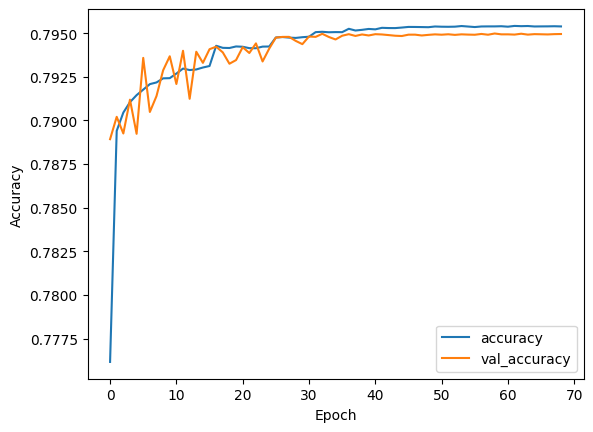

In [8]:
#plotting the accuracy of the first model
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

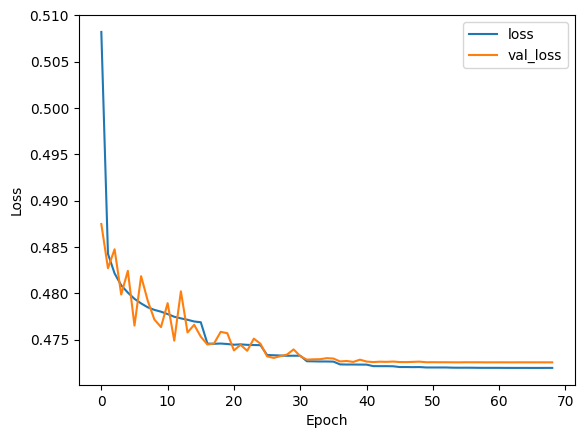

In [9]:
#plotting the loss over epoch for the first model
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [10]:
# Generate sequences of the test data of the first chain
X1_test_seq, y1_test_seq = rp.create_sequences(rp.fes.X1_test, rp.fes.y1_test, rp.seq_length)

# Predict the labels for the test set
y_pred1 = model1.predict(X1_test_seq)

#convert predictions to class labels
y_pred_classes1 = np.argmax(y_pred1, axis=1)

# Convert one-hot encoded true labels back to class labels
y_test_classes1 = np.argmax(y1_test_seq, axis=1)

54025/54025 [==============================] - 138s 3ms/step


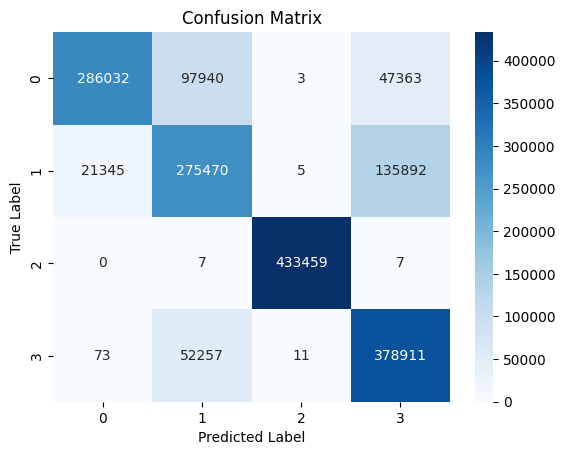

In [11]:
#plotting confusion matrix for the first model
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix1 = confusion_matrix(y_test_classes1, y_pred_classes1)
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

# Calculate metrics
precision_macro = precision_score(y_test_classes1, y_pred_classes1, average='macro')
recall_macro = recall_score(y_test_classes1, y_pred_classes1, average='macro')
f1_macro = f1_score(y_test_classes1, y_pred_classes1, average='macro')

precision_micro = precision_score(y_test_classes1, y_pred_classes1, average='micro')
recall_micro = recall_score(y_test_classes1, y_pred_classes1, average='micro')
f1_micro = f1_score(y_test_classes1, y_pred_classes1, average='micro')

precision_weighted = precision_score(y_test_classes1, y_pred_classes1, average='weighted')
recall_weighted = recall_score(y_test_classes1, y_pred_classes1, average='weighted')
f1_weighted = f1_score(y_test_classes1, y_pred_classes1, average='weighted')

# Create a summary table for F1, Recall, and Precision
metrics_summary = pd.DataFrame({
    'Metric': [
        'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)',
        'Precision (Micro)', 'Recall (Micro)', 'F1 Score (Micro)',
        'Precision (Weighted)', 'Recall (Weighted)', 'F1 Score (Weighted)'
    ],
    'Score': [
        precision_macro, recall_macro, f1_macro,
        precision_micro, recall_micro, f1_micro,
        precision_weighted, recall_weighted, f1_weighted
    ]
})

# Display the table
print(metrics_summary)

                 Metric     Score
0     Precision (Macro)  0.812861
1        Recall (Macro)  0.794584
2      F1 Score (Macro)  0.794740
3     Precision (Micro)  0.794708
4        Recall (Micro)  0.794708
5      F1 Score (Micro)  0.794708
6  Precision (Weighted)  0.812967
7     Recall (Weighted)  0.794708
8   F1 Score (Weighted)  0.794873


In [13]:
#save the first trained model
model1.save('model_SimpleRNN_214.h5')

/home/pipc06/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
# Train model 2
history2 = model2.fit(rp.X2_seq_train, rp.y2_seq_train, epochs=200, batch_size=256, verbose=2,
                      validation_data=(rp.X2_seq_val, rp.y2_seq_val),
                      callbacks=callbacks)

Epoch 1/200
16039/16039 - 240s - loss: 0.4720 - accuracy: 0.7960 - val_loss: 0.4442 - val_accuracy: 0.8104 - lr: 0.0010 - 240s/epoch - 15ms/step
Epoch 2/200
16039/16039 - 233s - loss: 0.4455 - accuracy: 0.8101 - val_loss: 0.4434 - val_accuracy: 0.8111 - lr: 0.0010 - 233s/epoch - 15ms/step
Epoch 3/200
16039/16039 - 231s - loss: 0.4440 - accuracy: 0.8109 - val_loss: 0.4417 - val_accuracy: 0.8114 - lr: 0.0010 - 231s/epoch - 14ms/step
Epoch 4/200
16039/16039 - 229s - loss: 0.4427 - accuracy: 0.8115 - val_loss: 0.4435 - val_accuracy: 0.8104 - lr: 0.0010 - 229s/epoch - 14ms/step
Epoch 5/200
16039/16039 - 229s - loss: 0.4419 - accuracy: 0.8120 - val_loss: 0.4384 - val_accuracy: 0.8140 - lr: 0.0010 - 229s/epoch - 14ms/step
Epoch 6/200
16039/16039 - 229s - loss: 0.4415 - accuracy: 0.8122 - val_loss: 0.4461 - val_accuracy: 0.8097 - lr: 0.0010 - 229s/epoch - 14ms/step
Epoch 7/200
16039/16039 - 209s - loss: 0.4411 - accuracy: 0.8125 - val_loss: 0.4406 - val_accuracy: 0.8126 - lr: 0.0010 - 209s/epo

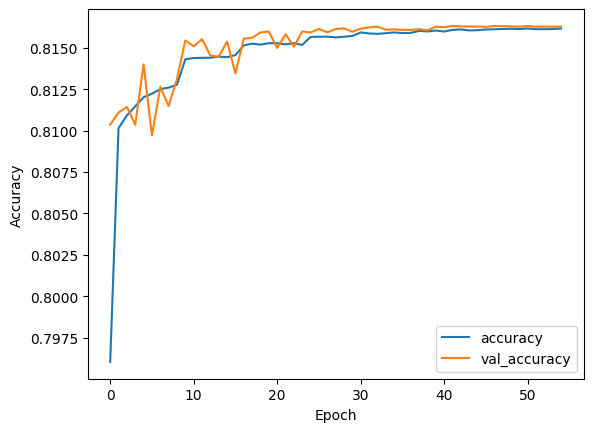

In [8]:
#plotting the accuracy of the second model
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

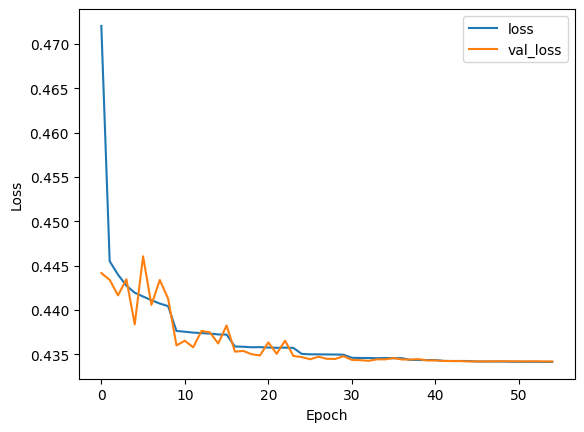

In [9]:
#plotting the loss over epoch for the second model
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [10]:
# Generate sequences of the test data of the second chain
X2_test_seq, y2_test_seq = rp.create_sequences(rp.fes.X2_test, rp.fes.y2_test, rp.seq_length)
# Predict the labels for the test set
y_pred2 = model2.predict(X2_test_seq)

#convert predictions to class labels
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Convert one-hot encoded true labels back to class labels
y_test_classes2 = np.argmax(y2_test_seq, axis=1)

53464/53464 [==============================] - 343s 6ms/step


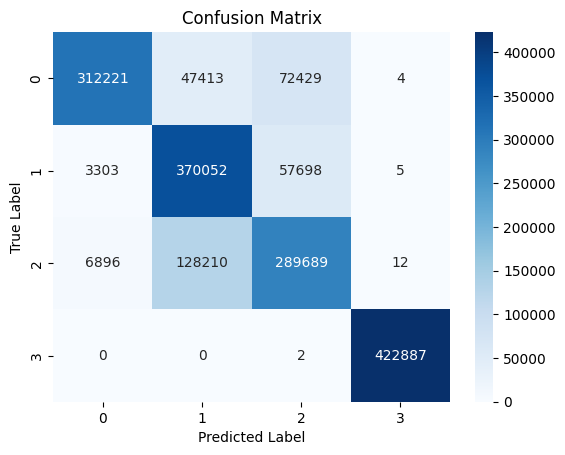

In [12]:
#plotting confusion matrix for the second model
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix2 = confusion_matrix(y_test_classes2, y_pred_classes2)
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

# Calculate metrics
precision_macro = precision_score(y_test_classes2, y_pred_classes2, average='macro')
recall_macro = recall_score(y_test_classes2, y_pred_classes2, average='macro')
f1_macro = f1_score(y_test_classes2, y_pred_classes2, average='macro')

precision_micro = precision_score(y_test_classes2, y_pred_classes2, average='micro')
recall_micro = recall_score(y_test_classes2, y_pred_classes2, average='micro')
f1_micro = f1_score(y_test_classes2, y_pred_classes2, average='micro')

precision_weighted = precision_score(y_test_classes2, y_pred_classes2, average='weighted')
recall_weighted = recall_score(y_test_classes2, y_pred_classes2, average='weighted')
f1_weighted = f1_score(y_test_classes2, y_pred_classes2, average='weighted')

# Create a summary table for F1, Recall, and Precision
metrics_summary = pd.DataFrame({
    'Metric': [
        'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)',
        'Precision (Micro)', 'Recall (Micro)', 'F1 Score (Micro)',
        'Precision (Weighted)', 'Recall (Weighted)', 'F1 Score (Weighted)'
    ],
    'Score': [
        precision_macro, recall_macro, f1_macro,
        precision_micro, recall_micro, f1_micro,
        precision_weighted, recall_weighted, f1_weighted
    ]
})

# Display the table
print(metrics_summary)

                 Metric     Score
0     Precision (Macro)  0.834127
1        Recall (Macro)  0.815755
2      F1 Score (Macro)  0.817826
3     Precision (Micro)  0.815310
4        Recall (Micro)  0.815310
5      F1 Score (Micro)  0.815310
6  Precision (Weighted)  0.833941
7     Recall (Weighted)  0.815310
8   F1 Score (Weighted)  0.817444


In [14]:
#save the second trained model
model2.save('model_SimpleRNN_212.h5')

/home/pipc06/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
